In [1]:
import tensorflow as tf
import csv

data_folder = '../../Calista/website-aesthetics-datasets-master/rating-based-dataset/preprocess/'

train_data_path = data_folder + 'train_means_list.csv'
test_data_path = data_folder + 'test_list.csv'
images_path = data_folder + 'resized'

def get_scores(scores_path):

    images = []
    scores = []

    with open(scores_path) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0

        for row in csv_reader:
            if line_count == 0:

                line_count += 1
            else:

                scores.append(float(row[1]))
                line_count += 1
                image_name = row[0]

                images.append(images_path + image_name)

    return (images, scores)

train_images, train_scores = get_scores(train_data_path)
test_images, test_scores = get_scores(test_data_path)

2024-07-10 21:34:38.681772: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-10 21:34:38.681801: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-10 21:34:38.682816: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-10 21:34:38.688604: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-10 21:34:39.308231: W tensorflow/compiler/tf2

In [2]:
import random
import numpy as np

# np.random.seed(2000)

temp = list(zip(train_images, train_scores))
random.shuffle(temp)

train_images, train_scores = zip(*temp)


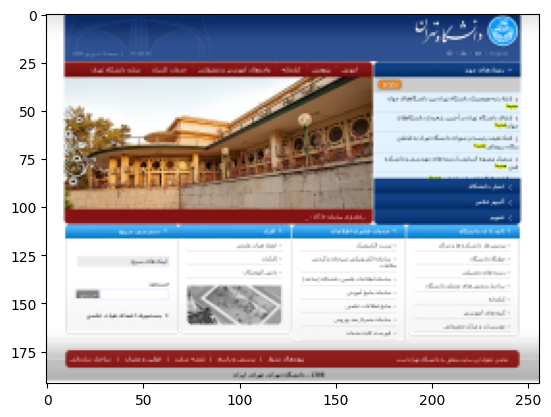

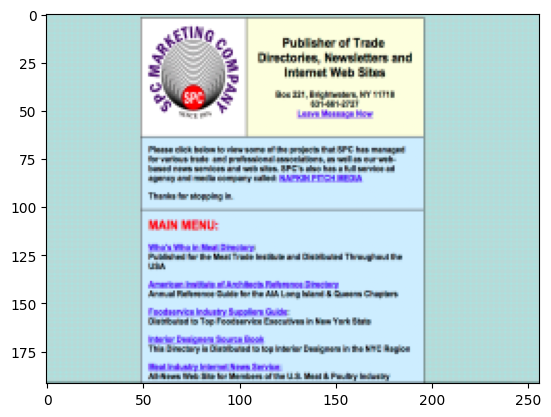

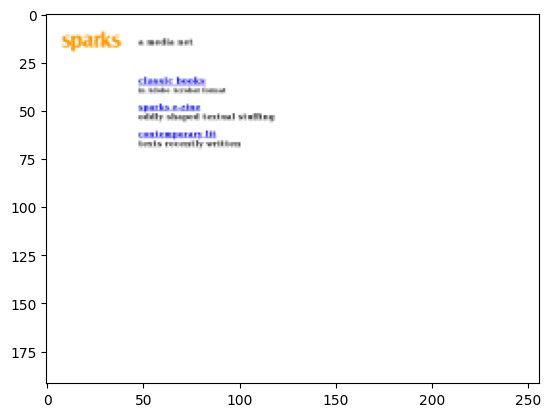

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib.image as mping
for ima in train_images[0:3]:
  img = mping.imread(ima)
  imgplot = plt.imshow(img)
  plt.show()

In [4]:
import cv2

width = 256
height = 192
channels = 3

def read_and_process_images(list_of_images):
  X = []

  for image in list_of_images:

    # images are already resized
    # X.append(cv2.resize(cv2.imread(image, cv2.IMREAD_COLOR), (width, height),
    #                     interpolation=cv2.INTER_AREA))

    X.append(cv2.imread(image, cv2.IMREAD_COLOR))

  return X


X_train = np.array(read_and_process_images(train_images))
y_train = np.array(train_scores)

X_val = np.array(read_and_process_images(test_images))
y_val = np.array(test_scores)

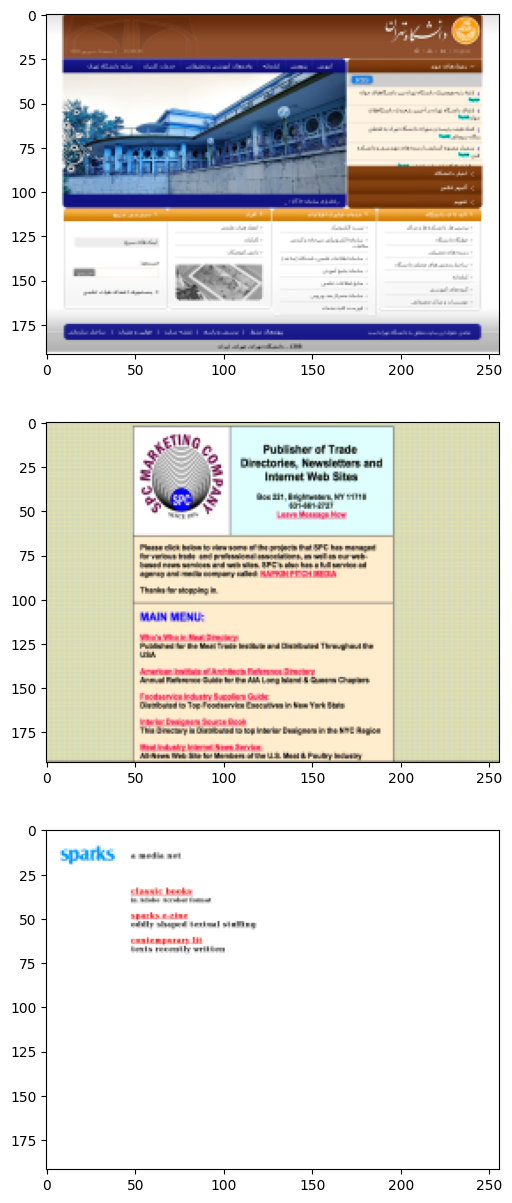

In [5]:
plt.figure(figsize=(25,15))
columns = 3

for i in range(columns):
  plt.subplot(columns, 1, i+1)
  plt.imshow(X_train[i])

In [6]:
ntrain = len(X_train)
nval = len(X_val)

print('Shape of rating_X_train is: ', X_train.shape)
print('Shape of rating_X_val is: ', X_val.shape)
print('Shape of rating_y_train is: ', y_train.shape)
print('Shape of rating_y_val is: ', y_val.shape)

Shape of rating_X_train is:  (300, 192, 256, 3)
Shape of rating_X_val is:  (98, 192, 256, 3)
Shape of rating_y_train is:  (300,)
Shape of rating_y_val is:  (98,)


In [7]:
import h5py

def traverse_datasets(hdf_file):

    def h5py_dataset_iterator(g, prefix=''):
        for key in g.keys():
            item = g[key]
            path = f'{prefix}/{key}'    
            if isinstance(item, h5py.Dataset): # test for dataset
                yield (path, item)
            elif isinstance(item, h5py.Group): # test for group (go down)
                yield from h5py_dataset_iterator(item, path)

    with h5py.File(hdf_file, 'r') as f:
        for path, _ in h5py_dataset_iterator(f):
            yield path

weights = {}
filename = '../../Calista/pretrainedModels/flickr_style.h5'

with h5py.File(filename, 'r') as f:
    for dset in traverse_datasets(filename):
        print('Path:', dset)
        # print('Shape:', f[dset].shape)
        # print('Data type:', f[dset].dtype)
        weights[dset] = f[dset][:]

conv1_bias = weights['/conv1/conv1/bias:0']
conv1_kernel = weights['/conv1/conv1/kernel:0']
conv2_bias = weights['/conv2/conv2/bias:0']
conv2_kernel = weights['/conv2/conv2/kernel:0']
conv3_bias = weights['/conv3/conv3/bias:0']
conv3_kernel = weights['/conv3/conv3/kernel:0']
conv4_bias = weights['/conv4/conv4/bias:0']
conv4_kernel = weights['/conv4/conv4/kernel:0']
conv5_bias = weights['/conv5/conv5/bias:0']
conv5_kernel = weights['/conv5/conv5/kernel:0']

Path: /conv1/conv1/bias:0
Path: /conv1/conv1/kernel:0
Path: /conv2/conv2/bias:0
Path: /conv2/conv2/kernel:0
Path: /conv3/conv3/bias:0
Path: /conv3/conv3/kernel:0
Path: /conv4/conv4/bias:0
Path: /conv4/conv4/kernel:0
Path: /conv5/conv5/bias:0
Path: /conv5/conv5/kernel:0
Path: /fc6/fc6/bias:0
Path: /fc6/fc6/kernel:0
Path: /fc7/fc7/bias:0
Path: /fc7/fc7/kernel:0
Path: /fc8_flickr/fc8_flickr/bias:0
Path: /fc8_flickr/fc8_flickr/kernel:0


In [8]:
from shared_feature_extractor import create_shared_feature_extractor
from rating_model import create_ratingModel
from comparison_model import create_comparisonModel
from tensorflow import keras
from keras import models
# import tensorflow as tf


# input_shape = (192, 256, 3)
shared_feature_extractor = create_shared_feature_extractor()
rating_model = create_ratingModel(shared_feature_extractor)
input_a, input_b, comparison_model = create_comparisonModel(shared_feature_extractor)

2024-07-10 21:34:41.387958: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 21:34:41.420926: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-10 21:34:41.421099: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [9]:
# rating_model = models.Model(inputs=shared_feature_extractor.input, outputs=rating_model.output, name='rating_model')

# comparison_model = models.Model(inputs=[input_a, input_b], outputs=comparison_model_output, name='comparison_model')

In [10]:
shared_feature_extractor.get_layer('conv1').set_weights([conv1_kernel[:, :, :, :], conv1_bias[:]])
shared_feature_extractor.get_layer('conv2_1').set_weights([conv2_kernel[:, :, :, :128], conv2_bias[:128]])
shared_feature_extractor.get_layer('conv2_2').set_weights([conv2_kernel[:, :, :, 128:], conv2_bias[128:]])
shared_feature_extractor.get_layer('conv3').set_weights([conv3_kernel[:, :, :, :], conv3_bias[:]])
shared_feature_extractor.get_layer('conv4_1').set_weights([conv4_kernel[:, :, :, :192], conv4_bias[:192]])
shared_feature_extractor.get_layer('conv4_2').set_weights([conv4_kernel[:, :, :, 192:], conv4_bias[192:]])
shared_feature_extractor.get_layer('conv5_1').set_weights([conv5_kernel[:, :, :, :128], conv5_bias[:128]])
shared_feature_extractor.get_layer('conv5_2').set_weights([conv5_kernel[:, :, :, 128:], conv5_bias[128:]])

# rating_model.summary()
# comparison_model.summary()
rating_model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 im_data (InputLayer)        [(None, 192, 256, 3)]        0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 46, 62, 96)           34944     ['im_data[0][0]']             
                                                                                                  
 pool1 (MaxPooling2D)        (None, 23, 31, 96)           0         ['conv1[0][0]']               
                                                                                                  
 norm1 (LRN)                 (None, 23, 31, 96)           0         ['pool1[0][0]']               
                                                                                              

In [11]:
def euclidean_distance_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 0.5 * tf.reduce_mean(tf.square(y_pred - y_true), axis=-1)

    # Custom RMSE function for rating output
def rating_rmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true), axis=-1))

In [12]:
# from keras.preprocessing.image import ImageDataGenerator
# batch_size = 32

# train_datagen = ImageDataGenerator(rescale = 1./255)
# val_datagen =  ImageDataGenerator(rescale = 1./255)

# train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
# val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

batch_size = 32
from data_generator import rating_data_generator


# Define the output signature for the rating generator
rating_output_signature = (
    tf.TensorSpec(shape=(None, 192, 256, 3), dtype=tf.float32),
    tf.TensorSpec(shape=(None,), dtype=tf.float32)
)

# Create TensorFlow Dataset objects for rating task
rating_gen_train = tf.data.Dataset.from_generator(
    lambda: rating_data_generator(X_train, y_train, batch_size),
    output_signature=rating_output_signature
)

rating_gen_val = tf.data.Dataset.from_generator(
    lambda: rating_data_generator(X_val, y_val, batch_size),
    output_signature=rating_output_signature
) 
#repeat???

In [ ]:

# decay = 1e-4

epochs = 90
base_lr = 0.001
initial_learning_rate = base_lr
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

adam_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

sgd = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)


# rating_model.compile(loss=euclidean_distance_loss , optimizer=sgd, metrics=[rmse])
# comparison_model.compile(loss=bradley_terry_loss, optimizer=adam_optimizer, metrics=[rmse])

rating_model.compile(loss=euclidean_distance_loss, optimizer=sgd,
                    metrics={
    'rating_output' : [rating_rmse],
     })


In [ ]:
# Fit the model
history = rating_model.fit(rating_gen_train,
    steps_per_epoch = ntrain // batch_size,
    epochs = epochs,
    validation_data = rating_gen_val,
    validation_steps = nval // batch_size)


Epoch 1/90


2024-07-10 18:29:42.988936: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/dropout1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


9/9 [==============================] - 2s 88ms/step - loss: 11.4818 - rating_rmse: 4.2537 - val_loss: 10.9744 - val_rating_rmse: 4.1537
Epoch 2/90
9/9 [==============================] - 1s 62ms/step - loss: 10.5049 - rating_rmse: 4.0244 - val_loss: 9.8688 - val_rating_rmse: 3.8802
Epoch 3/90
9/9 [==============================] - 1s 60ms/step - loss: 9.3658 - rating_rmse: 3.7275 - val_loss: 8.4985 - val_rating_rmse: 3.5088
Epoch 4/90
9/9 [==============================] - 1s 61ms/step - loss: 8.1984 - rating_rmse: 3.3934 - val_loss: 7.4266 - val_rating_rmse: 3.1862
Epoch 5/90
9/9 [==============================] - 1s 61ms/step - loss: 6.5472 - rating_rmse: 2.8576 - val_loss: 4.6185 - val_rating_rmse: 2.1420
Epoch 6/90
9/9 [==============================] - 1s 58ms/step - loss: 2.9533 - rating_rmse: 1.1435 - val_loss: 2.4653 - val_rating_rmse: 0.8952
Epoch 7/90
9/9 [==============================] - 1s 57ms/step - loss: 2.4908 - rating_rmse: 0.8730 - val_loss: 2.3610 - val_rating_rmse: 

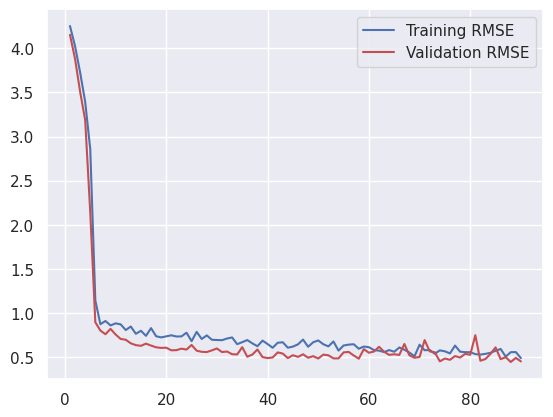

In [ ]:
rmse = history.history["rating_rmse"]
val_rmse = history.history["val_rating_rmse"]

epochs_x = range(1, len(rmse) + 1)

plt.plot(epochs_x, rmse, 'b', label='Training RMSE')
plt.plot(epochs_x, val_rmse, 'r', label='Validation RMSE')

plt.legend()



In [ ]:
from scipy import stats

def pearsonr_ci(x,y,alpha=0.05):
    ''' calculate Pearson correlation along with the confidence interval using scipy and numpy
    Parameters
    ----------
    x, y : iterable object such as a list or np.array
      Input for correlation calculation
    alpha : float
      Significance level. 0.05 by default
    Returns
    -------
    r : float
      Pearson's correlation coefficient
    pval : float
      The corresponding p value
    lo, hi : float
      The lower and upper bound of confidence intervals
    '''
    N = len(x)
    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(N-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

In [ ]:

predictions = []

X_val = X_val / 255.0
for img in X_val:
  img = img.reshape(1, 192, 256, 3)
  pred = rating_model.predict(img)
  predictions.append(float(pred))

predictions = np.array(predictions)

1/1 [==============================] - 0s 141ms/step


1/1 [==============================] - ETA: 0s

/tmp/ipykernel_489871/3539075418.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predictions.append(float(pred))


1/1 [==============================] - 0s 14ms/step


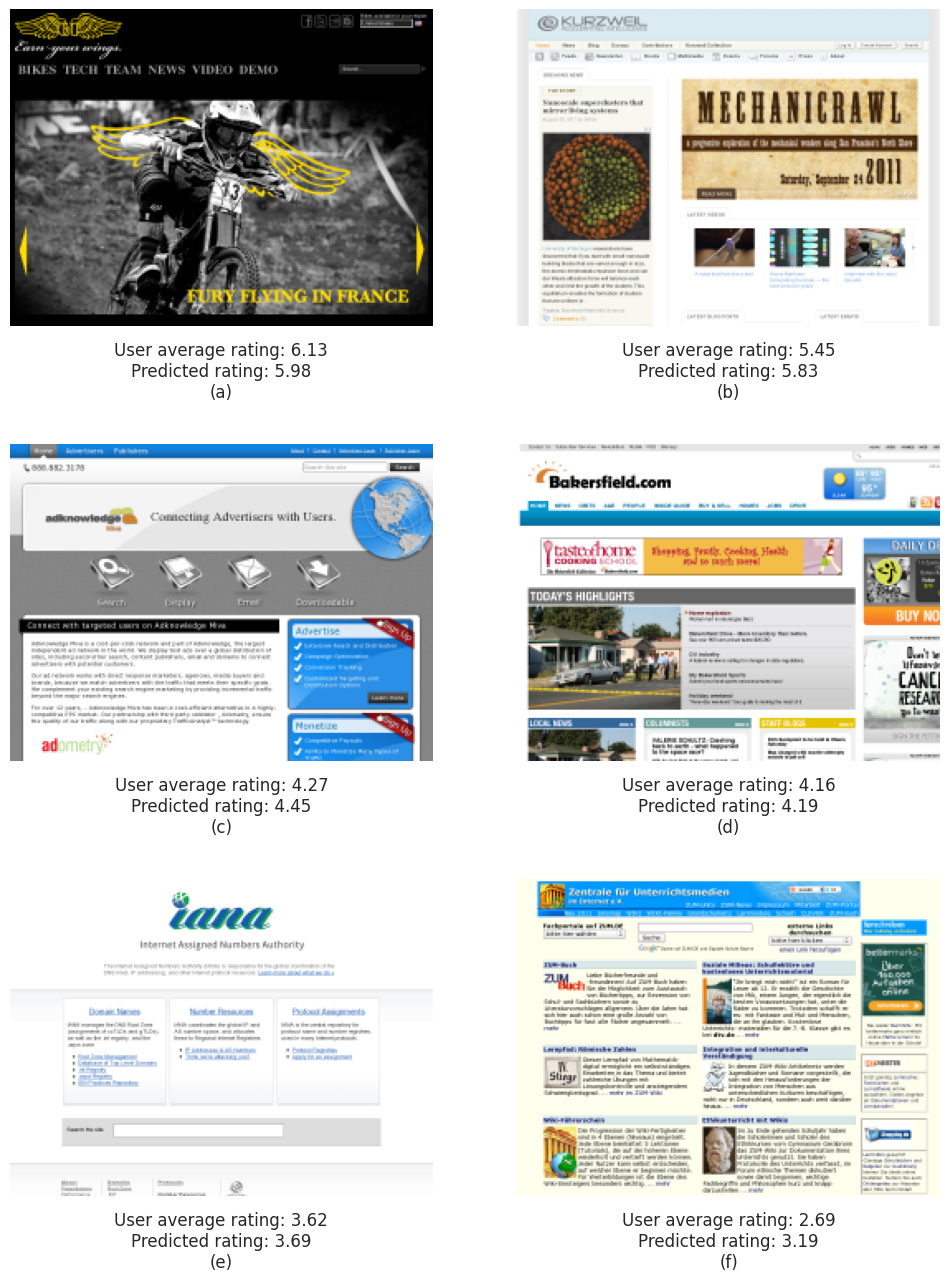

In [ ]:
image_ids = [87, 45, 49, 94, 14, 83] # test image IDs sorted in descending order according to the website's aesthetics level

fig = plt.figure(figsize=(12, 16))
i = 1
for id in image_ids:
  if 'english' in test_images[id]:
    path = images_path + '/english_resized/' + test_images[id].rsplit('/', 1)[1]
  else:
    path = images_path + '/foreign_resized/' + test_images[id].rsplit('/', 1)[1]

  plt.subplot(len(image_ids)//2, 2, i)
  img = mping.imread(path)
  plt.title('User average rating: ' + str(np.round(y_val[id],2)) + '\nPredicted rating: ' + str(np.round(predictions[id],2)) + '\n(' + chr(97+i-1) + ')', y=-0.25)
  plt.axis('off')
  plt.imshow(img)

  i += 1

plt.show()

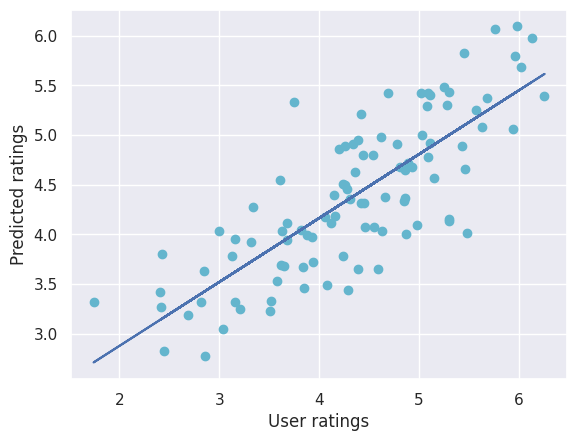

In [ ]:
from numpy.polynomial.polynomial import polyfit
b, m = polyfit(y_val, predictions, 1)

fig = plt.figure()
plt.scatter(y_val, predictions, c='c')
plt.plot(y_val, b + m * y_val, '-', c='b')
plt.xlabel('User ratings')
plt.ylabel('Predicted ratings')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

corr, p, lo, hi = pearsonr_ci(y_val, predictions)
print('Pearsons correlation: r=%.2f, p=%.2e, CI=[%.2f, %.2f]' % (corr, p, lo, hi))
rmse_test = sqrt(mean_squared_error(y_val, predictions))
print('RMSE: %.3f' % rmse_test)

Pearsons correlation: r=0.80, p=1.04e-22, CI=[0.71, 0.86]
RMSE: 0.582


<Figure size 640x480 with 0 Axes>

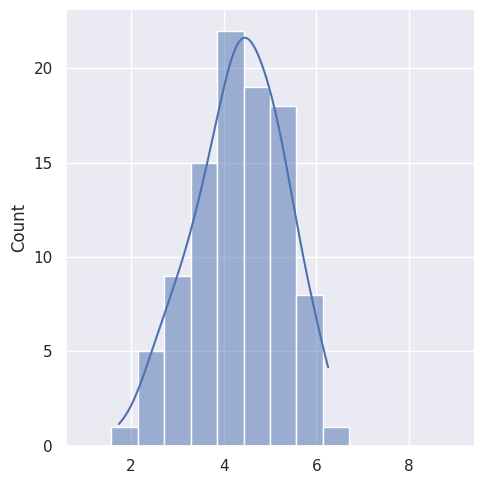

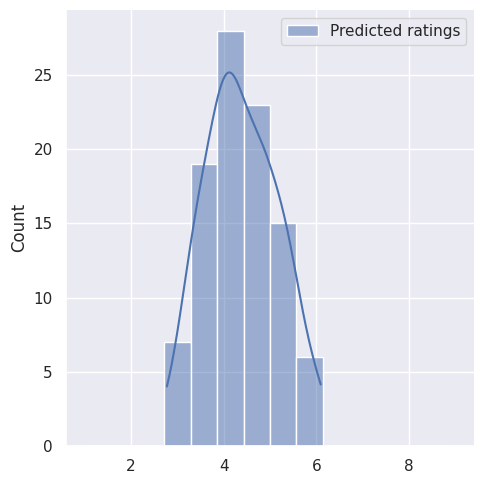

: 

In [ ]:
import seaborn as sns

fig = plt.figure()
sns.set(color_codes=True)

bins = np.linspace(1, 9, num=15)

sns.displot(y_val, bins=bins, label='User ratings', kde=True)

sns.displot(predictions, bins=bins, label='Predicted ratings', kde=True)

plt.legend()

plt.show()
